In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
sn.set(style="whitegrid")

### Cargar Datos

In [2]:
Datos = Tachos('../Alemania_Reducida.csv')
data = Datos[['PIB (US$ a precios constantes de 2010)','Gasto de consumo final de los hogares (US$ a precios constantes de 2010)','Gasto nacional bruto (US$ a precios constantes de 2010)']].dropna(axis = 0)
data.columns = ['PIB','Inversión','Gasto']
data.dropna(axis =1, inplace= True)
data.index = pd.date_range(start='1970-12-31', periods=len(data), freq='Y')

In [35]:
Columnas(Datos,'interés')

Tasa de interés de los depósitos (%)
Tasa de interés real (%)
Diferencial de tasas de interés (tasa activa menos tasa pasiva, %)
Tasa de interés activa (%)


### Analisis de Estacionariedad a las Variables

In [11]:
DFuller(data['PIB'])
DFuller(data['Gasto'])
DFuller(data['Inversión'].diff().dropna())

Estadístico ADF: -0.6667260211077259
Valor p: 0.8551810506341725
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -0.6160967317000873
Valor p: 0.8673031853643212
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -5.482258695668724
Valor p: 2.270472199649756e-06
Rechazamos la hipótesis nula; la serie es estacionaria.


In [12]:
data['Inversión'] = data['Inversión'].diff()
data.dropna(axis =0 ,inplace= True)

### Amalisis de Correlacion de las Variables

### Analisis de Cointegración

In [14]:
print('Al 99% de confianza')
Johansen_Test(data,1,0,2)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.7055    66.7925    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    21.9288    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    3.0358    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.7055    91.757    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    24.9646    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    3.0358    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.


### Modelo Inicial

In [20]:

lag_order = select_order(data, exog = data['Inversión'], maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 5, BIC -> 0, FPE -> 5, HQIC ->  5>


In [22]:
model = VECM(data[['PIB','Gasto']],exog = data['Inversión'] ,coint_rank= 2, k_ar_diff= 5)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[-0.11975343  0.14833934]
 [ 0.0049161   0.00673401]]


In [23]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation PIB
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1          1.3423      0.227      5.909      0.000       0.897       1.788
L1.PIB        -0.3491      0.228     -1.531      0.126      -0.796       0.098
L1.Gasto       0.0945      0.257      0.368      0.713      -0.408       0.597
L2.PIB        -0.6170      0.230     -2.678      0.007      -1.069      -0.165
L2.Gasto       0.4769      0.256      1.863      0.063      -0.025       0.979
L3.PIB        -0.2646      0.230     -1.151      0.250      -0.715       0.186
L3.Gasto       0.0286      0.234      0.122      0.903      -0.430       0.488
L4.PIB        -0.0962      0.231     -0.417      0.677      -0.548       0.356
L4.Gasto      -0.0126      0.246     -0.051      0.959      -0.495       0.470
L5.PIB        -0.2909      0.237     -1.227     

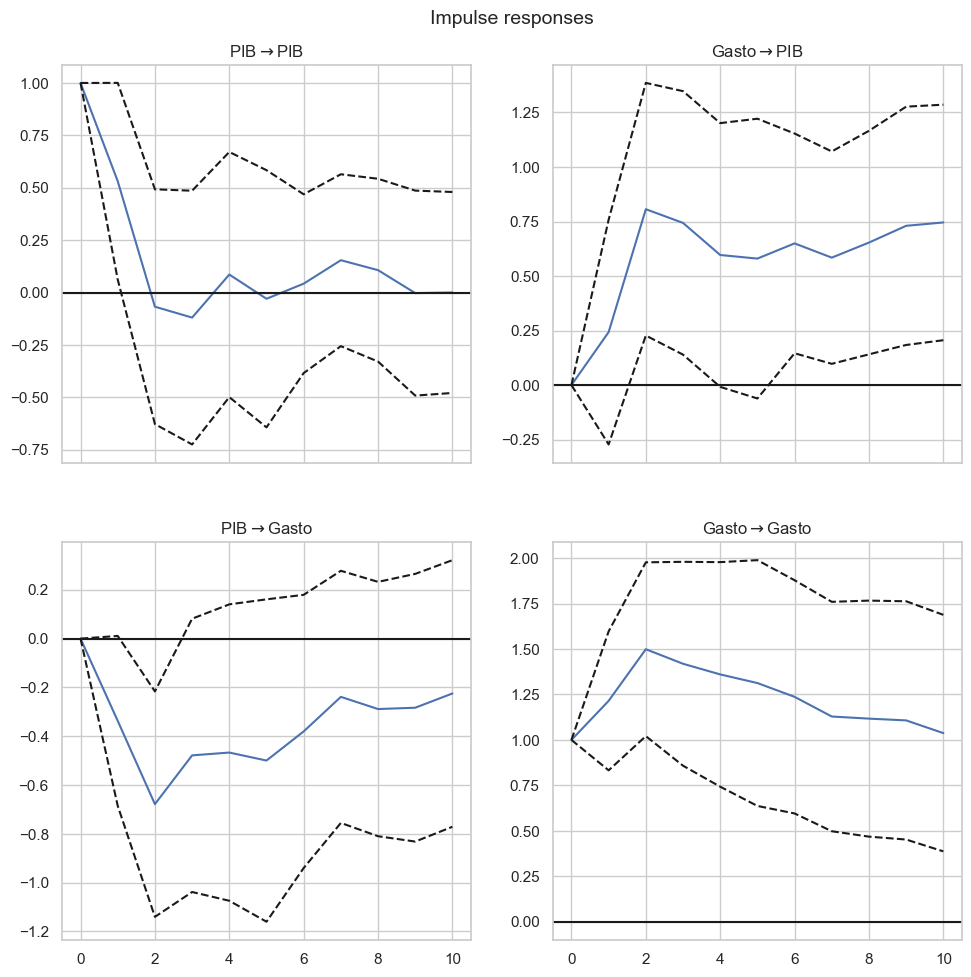

In [24]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()